### Loading requirements

In [2]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
import datetime as dt
import csv

from scipy import sparse
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import Lasso, LinearRegression, LogisticRegression, RidgeClassifier
from sklearn.metrics import classification_report

---
### Loading dataset + defining functions

In [31]:
science_df = pd.read_csv('datasets\\science_dataset_updated2.csv') #Loads dataset
sports_df = pd.read_csv('datasets\\sports_dataset_updated2.csv') #Loads dataset
gaming_df = pd.read_csv('datasets\\gaming_dataset_updated2.csv') #Loads dataset
wsb_df = pd.read_csv('datasets\\wsb_dataset_updated2.csv') #Loads dataset

In [36]:
print('Original title: ', gaming_df.title[1])
print('Processed title: ', gaming_df.title_cleaned[1])

Original title:  Minecraft Map Banned In 20+ Countries
Processed title:  ['minecraft', 'map', 'banned', 'countries']


In [174]:
master_df = pd.concat([science_df, sports_df, gaming_df, wsb_df], axis=0)
master_df.head()

,post_ID,title,url,author,timestamp,comms_num,permalink,body,Flair,title length,24h_posttime,score,title_cleaned,score_class,has_body_text,id
0,j2xstb,Framing COVID-19: How we conceptualize and dis...,https://doi.org/10.1371/journal.pone.0240010,scientist_1337,2020-10-01 02:03:19,0,/r/science/comments/j2xstb/framing_covid19_how...,NaN,Social Science,199,2,9,"[framing, covid, conceptualize, discuss, pande...",Last 80%,0.0,NaN
1,j2xtrh,Framing COVID-19: How we conceptualize and dis...,https://journals.plos.org/plosone/article?id=1...,scientist_1337,2020-10-01 02:05:02,0,/r/science/comments/j2xtrh/framing_covid19_how...,NaN,Social Science,199,2,1,"[framing, covid, conceptualize, discuss, pande...",Last 80%,0.0,NaN
2,j2yv6u,whats science?,https://www.twitch.tv/tippothehippo,directorjames,2020-10-01 03:10:39,2,/r/science/comments/j2yv6u/whats_science/,NaN,Social Science,14,3,1,"[whats, science]",Last 80%,0.0,NaN
3,j2yzup,Providing decent living with minimum energy: A...,https://www.sciencedirect.com/science/article/...,Helicase21,2020-10-01 03:19:04,7,/r/science/comments/j2yzup/providing_decent_li...,NaN,Environment,62,3,17,"[providing, decent, living, minimum, energy, g...",Last 80%,0.0,NaN
4,j2zhbn,Neurotoxic effects associated with antibiotic use,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,shripajeetmaharaj,2020-10-01 03:50:43,1,/r/science/comments/j2zhbn/neurotoxic_effects_...,NaN,Biology,49,3,2,"[neurotoxic, effects, associated, antibiotic, ...",Last 80%,0.0,NaN


In [175]:
preprocess_text_col(master_df, 'title')

In [77]:
stop_words = set(stopwords.words('english')) #Defines stopwords
ps = PorterStemmer() #Defines stemmer

def preprocess_text_col(dataframe, column_name): #Function for preprocessing text data for model-use by adding 'title-cleaned' column to given dataframe
    def remove_punctuation(text): #Removes punctuation from string e.g. 'This is a string. This is another string' → 'this is a string This is another string' 
        no_punct=[words.lower() for words in text if words not in string.punctuation and words.isdigit() == False]
        words_wo_punct=''.join(no_punct)
        return words_wo_punct
    def tokenize(text): #Tokenizes string e.g. 'This is a string' → ['this', 'is', 'a', 'string']
        split=re.split("\W+", text)
        return split
    def remove_stopwords(text): #Removes stopwords list of strings e.g. ['this', 'is', 'a', 'string'] → ['string']
        text=[word for word in text if word not in stop_words and word != '']
        return text
    def stem_nested_list(lst): #Stems words in a nested list and returns a nested list with stemmed words
        master_list = []
        for x in lst:
            stemmed_list = [ps.stem(word) for word in x]
            master_list.append(stemmed_list)
        return master_list
    
    title_wo_punct = [remove_punctuation(x) for x in dataframe[column_name]]
    title_wo_punct_split = [tokenize(word) for word in title_wo_punct]
    title_wo_punct_split_stopwords = [remove_stopwords(word) for word in title_wo_punct_split]
    dataframe['title_cleaned'] = title_wo_punct_split_stopwords
#     dataframe['title_cleaned'] = stem_nested_list(title_wo_punct_split_stopwords)    

def create_features(dataframe):
    dataframe['timestamp'] = pd.to_datetime(dataframe['timestamp']) #Changing 'timestamp' column to dtype = datetime
    dataframe['24h_posttime'] = dataframe['timestamp'].dt.hour #Adding hour posttime to dataset
    
    dataframe['score_class'] = "" #Creating the score_class column in the dataframe and filling it with empty strings
    
    dataframe['body'] = dataframe['body'].astype(str)
    dataframe.loc[(dataframe['body'] == 'nan') | (dataframe['body'] == '[deleted]'), 'has_body_text'] = int(0) 
    dataframe.loc[(dataframe['body'] != 'nan') & (dataframe['body'] != '[deleted]'), 'has_body_text'] = int(1)
#     dataframe['has_body_text'] = dataframe['has_body_text'].astype(int)
    
    for x in range(len(dataframe)): #Generates classes for score percentiles
        if dataframe['score'][x] >= dataframe.score.quantile(0.99):
            dataframe['score_class'][x] = 'Top 1%'
        elif dataframe['score'][x] >= dataframe.score.quantile(0.95):
            dataframe['score_class'][x] = 'Top 5%'
        elif dataframe['score'][x] >= dataframe.score.quantile(0.9):
            dataframe['score_class'][x] = 'Top 10%'
        elif dataframe['score'][x] >= dataframe.score.quantile(0.8):
            dataframe['score_class'][x] = 'Top 20%'
        else:
            dataframe['score_class'][x] = 'Last 80%'
    
def test_model(model): #Function for testing model(s)
    if type(model) == list:
        for x in range(len(model)):
            print("Training score for {}: {:.3f}".format(str(model[x]), model[x].score(X_train, y_train)))
            print("Test score for {}: {:.2f}\n".format(str(model[x]), model[x].score(X_test, y_test)))
    else:
        print("Training score for {}: {:.3f}".format(str(model), model.score(X_train, y_train)))
        print("Test score for {}: {:.2f}".format(str(model), model.score(X_test, y_test)))
        
def col_to_matrix(dataframe, column): #Function for converting a column from a pd.dataframe into a scipy.sparse.csr_matrix
    matrix = dataframe[column].values[np.newaxis] #Creating 2D np array from column by adding an axis to original 1D array (df[col].values)
    matrix = matrix.T #Transposing (rotating) array e.g. (1, 823) to (823, 1)
    matrix = sparse.csr_matrix(matrix) #Creating matrix from array
    return matrix

---
### Preprocessing text-data for model-use

In [90]:
begin_time = dt.datetime.now()

def vectorize_dataframe(dataframe):
    post_time = col_to_matrix(dataframe, '24h_posttime')
    title_len = col_to_matrix(dataframe, 'title length')
    has_body_text = col_to_matrix(dataframe, 'has_body_text')
    preprocess_text_col(dataframe, 'title')

    vectorizerbow = CountVectorizer(lowercase = False, analyzer=lambda x: x)
    tfidfvectorizer = TfidfVectorizer(lowercase = False, analyzer=lambda x: x)

    vectorizer = vectorizerbow
    titles_vectorized_bow = vectorizer.fit_transform(dataframe['title_cleaned'])

    titles_vectorized_bow = sparse.hstack((post_time, titles_vectorized_bow)) #Adding posttime column to matrix
    titles_vectorized_bow = sparse.hstack((title_len, titles_vectorized_bow)) #Adding title_length column to matrix
    titles_vectorized_bow = sparse.hstack((has_body_text, titles_vectorized_bow)) #Adding has_body_text column to matrix
    return titles_vectorized_bow

print('Time spent (hh:mm:ss):', dt.datetime.now() - begin_time)

Time spent (hh:mm:ss): 0:00:00


---
### Creating, training and testing models

In [179]:
vectorize_dataframe(master_df)
word = 'gme'
print(word, 3+vectorizerbow.vocabulary_[word])
print('Max num use:', titles_vectorized_bow_df[3+vectorizerbow.vocabulary_[word]].max())

gme 6073
Max num use: 4.0


In [165]:
index = 6810
wsb_0 = wsb_df.loc[titles_vectorized_bow_df[index] == 0]
wsb_1 = wsb_df.loc[titles_vectorized_bow_df[index] == 1]
wsb_2 = wsb_df.loc[titles_vectorized_bow_df[index] == 2]
wsb_3 = wsb_df.loc[titles_vectorized_bow_df[index] == 3]
wsb_4 = wsb_df.loc[titles_vectorized_bow_df[index] == 4]
wsb_5 = wsb_df.loc[titles_vectorized_bow_df[index] == 5]

print('0', wsb_0.score.mean())
print('1', wsb_1.score.mean())
print('2', wsb_2.score.mean())
print('3', wsb_3.score.mean())
print('4', wsb_4.score.mean())
print('5', wsb_5.score.mean())
print(len(wsb_4))

0 949.1679249836246
1 729.2272727272727
2 313.6666666666667
3 652.0222222222222
4 1487.1
5 47.857142857142854
10


<AxesSubplot:ylabel='Count'>

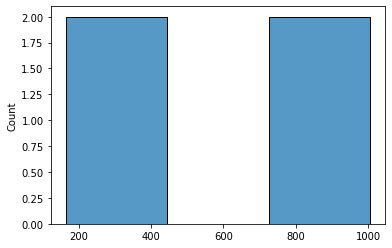

In [161]:
sns.histplot(x=[0, 1, 2, 3, 4],  = [wsb_0.score.mean(), wsb_2.score.mean(), wsb_3.score.mean(), wsb_4.score.mean(), wsb_5.score.mean()])

In [181]:
vect_vocab_sorted = dict(sorted(vectorizer.vocabulary_.items(), key=lambda item: item[1])) # Sorting dictionary of word:vector_index by vector_index
titles_vectorized_bow_df = pd.DataFrame(titles_vectorized_bow.toarray()) # Creating DataFrame from vectorized titles
titles_vectorized_bow_df = titles_vectorized_bow_df.drop([0, 1, 2], axis=1) # Removing 'title_length', 'has_body_text' & '24h_posstime' columns

vocab_dict = {}

sum_vect = titles_vectorized_bow_df.sum(axis=0) #dataframe with sums of all vects across all rows

for x in range(len(vect_vocab_sorted)): #Creating a dictionary consisting of word:sum pairs
    vocab_dict[list(vect_vocab_sorted)[x]] = list(sum_vect)[x]

sorted_vocab = dict(sorted(vocab_dict.items(), key=lambda item: item[1], reverse=True)) #Sorting the word:sum pairs by sum
sorted_vocab

MemoryError: Unable to allocate 31.4 GiB for an array with shape (86225, 48927) and data type float64

In [ ]:
begin_time = dt.datetime.now()

target = master_df.score_class

X_train, X_test, y_train, y_test = train_test_split(vectorize_dataframe(master_df), target, test_size = 0.2, random_state = 2021)

results = {'Model':'Score'}
for x in [0.01, 0.1, 1, 5, 10, 20]:
    ridge = RidgeClassifier(alpha = x, max_iter=5000).fit(X_train, y_train)
    results['ridge_training '+ str(x)] = ridge.score(X_train, y_train)
    results['ridge_test '+ str(x)] = ridge.score(X_test, y_test)
    
ridge_time = dt.datetime.now()
print('ridge done ', ridge_time - begin_time)

# SVC_model = SVC().fit(X_train, y_train)
# results['svc_training'] = SVC_model.score(X_train, y_train)
# results['svc_test'] = SVC_model.score(X_test, y_test)

svc_time = dt.datetime.now()
# print('svc done ', svc_time - ridge_time)

for x in range(1, 8):
    print('Neighbors:', x)
    start_time = dt.datetime.now()
    knn = KNeighborsClassifier(n_neighbors = x, n_jobs=-1).fit(X_train, y_train)
    results['knn_training '+ str(x)] = knn.score(X_train, y_train)
    train_time = dt.datetime.now()
    print('train score logged', train_time - start_time)
    results['knn_test '+ str(x)] = knn.score(X_test, y_test)
    print('test score logged', dt.datetime.now() - train_time)

print('knn done ', dt.datetime.now() - svc_time)

for x in [20, 50, 70, 100]:
    print('Tree count =', x, '     running...')
    for y in [50, 100, 200, 300]:
        forest = RandomForestClassifier(n_estimators = x, max_depth = y).fit(X_train, y_train)
        results['forest_training trees:'+ str(x) + ' dpth: '+str(y)] = forest.score(X_train, y_train)
        results['forest_test trees:'+ str(x) + ' dpth: '+str(y)] = forest.score(X_test, y_test)
        
for y in [50, 100, 200, 300]:
    dtree = DecisionTreeClassifier(max_depth = y).fit(X_train, y_train)
    results['dtree_training ' + ' dpth: '+str(y)] = dtree.score(X_train, y_train)
    results['dtree_test ' + ' dpth: '+str(y)] = dtree.score(X_test, y_test)

print('\nALL DONE! - Total time spent training/testing (hh:mm:ss):', dt.datetime.now() - begin_time)

ridge done  0:00:22.408795
Neighbors: 1
train score logged 0:03:26.738598
test score logged 0:00:48.213553
Neighbors: 2


In [91]:
begin_time = dt.datetime.now()

X_train, X_test, y_train, y_test = train_test_split(titles_vectorized_bow, target, test_size = 0.2, random_state = 2021)

XX_test = vectorize_dataframe(gaming_df)
yy_test = gaming_df.score_class

results_x = {'Model':'Score'}
for x in [0.01, 0.1, 1, 5, 10, 20]:
    ridge = RidgeClassifier(alpha = x, max_iter=5000).fit(X_train, y_train)
    results_x['ridge '+ str(x)] = ridge.score(XX_test, yy_test)
    
ridge_time = dt.datetime.now()
print('ridge done ', ridge_time - begin_time)

# SVC_model = SVC().fit(X_train, y_train)
# results['svc_training'] = SVC_model.score(X_train, y_train)
# results['svc_test'] = SVC_model.score(X_test, y_test)

svc_time = dt.datetime.now()
# print('svc done ', svc_time - ridge_time)

for x in range(1, 8):
    print('Neighbors:', x)
    start_time = dt.datetime.now()
    knn = KNeighborsClassifier(n_neighbors = x, n_jobs=-1).fit(X_train, y_train)
    results_x['knn '+ str(x)] = knn.score(XX_test, yy_test)
    train_time = dt.datetime.now()
    print('score logged', train_time - start_time)

print('knn done ', dt.datetime.now() - svc_time)

for x in [20, 50, 70, 100]:
    print('Tree count =', x, '     running...')
    for y in [50, 100, 200, 300]:
        forest = RandomForestClassifier(n_estimators = x, max_depth = y).fit(X_train, y_train)
        results_x['forest | trees:'+ str(x) + ', dpth: '+str(y)] = forest.score(XX_test, yy_test)
        
for y in [50, 100, 200, 300]:
    dtree = DecisionTreeClassifier(max_depth = y).fit(X_train, y_train)
    results_x['dtree |' + ' dpth: '+str(y)] = dtree.score(X_train, yy_test)
print('\nALL DONE! - Total time spent training/testing (hh:mm:ss):', dt.datetime.now() - begin_time)

ValueError: X has 23796 features per sample; expecting 16384

In [171]:
for k, v in results.items():
    print(k,v)

Model Score
ridge_training 0.01 0.9928714000570288
ridge_test 0.01 0.6670467502850627
ridge_training 0.1 0.9923011120615911
ridge_test 0.1 0.7023945267958951
ridge_training 1 0.9887368120901056
ridge_test 1 0.7331812998859749
ridge_training 5 0.9518106643855146
ridge_test 5 0.7542759407069556
ridge_training 10 0.9252922725976618
ridge_test 10 0.7588369441277081
ridge_training 20 0.8956372968349017
ridge_test 20 0.7679589509692132
knn_training 1 0.9985742800114058
knn_test 1 0.6864310148232611
knn_training 2 0.8448816652409467
knn_test 2 0.7565564424173318
knn_training 3 0.831194753350442
knn_test 3 0.758266818700114
knn_training 4 0.8197889934416881
knn_test 4 0.7668187001140251
knn_training 5 0.8136583974907328
knn_test 5 0.7753705815279361
knn_training 6 0.8095238095238095
knn_test 6 0.7805017103762828
knn_training 7 0.8058169375534645
knn_test 7 0.7770809578107184
forest_training trees:20 dpth: 50 0.8093812375249501
forest_test trees:20 dpth: 50 0.7890535917901939
forest_training tr

In [172]:
a_file = open("datasets\\\model_results\\unigram_science.csv", "w")

writer = csv.writer(a_file)
for k, v in results.items():
    writer.writerow([k, v])

a_file.close()

In [60]:
result_df2 = pd.read_csv('datasets\\model_results\\unigram_wsb.csv')

result_df2.head(30)

,Model,Score
0,ridge_training 0.01,0.993157
1,ridge_test 0.01,0.669327
2,ridge_training 0.1,0.992444
3,ridge_test 0.1,0.702965
4,ridge_training 1,0.988879
5,ridge_test 1,0.733751
6,ridge_training 5,0.951668
7,ridge_test 5,0.754276
8,ridge_training 10,0.925150
9,ridge_test 10,0.759407


In [25]:
begin_time = dt.datetime.now()

forest = RandomForestClassifier(n_estimators = 100).fit(X_train, y_train)
test_model(forest)

train_end_time = dt.datetime.now()
print('Time spent training (hh:mm:ss):',  train_end_time - begin_time)

MemoryError: could not allocate 41877504 bytes

In [5]:
feature_names_total = vectorizer.get_feature_names()
feature_names_total.extend(['posttime', 'title_length'])
sorted_coefs_desc = sorted(list(zip(list(feature_names_total), logreg.coef_[0])), key = lambda e: e[1], reverse=True)
sorted_coefs_asc = sorted(list(zip(list(feature_names_total), logreg.coef_[0])), key = lambda e: e[1])
features_forest = sorted(list(zip(list(feature_names_total), forest.feature_importances_)), key = lambda e: e[1], reverse=True)
# print(features_forest[:10], '\n')

for x in range(10):
    print(sorted_coefs_desc[x])

print('\n')
for x in range(10):
    
    print(sorted_coefs_asc[x])
for x in range(len(sorted_coefs_desc)):
    if sorted_coefs_desc[x][0] == 'posttime' :
        print(sorted_coefs_desc[x])
    else:
        pass
for x in range(len(sorted_coefs_desc)):
    if sorted_coefs_desc[x][0] == 'title_length' :
        print(sorted_coefs_desc[x])
    else:
        pass

('aaai', 0.43624606175774516)
('visualization', 0.3223039299815076)
('agedependent', 0.3194857417795549)
('ampamp', 0.2989954111354649)
('aggravates', 0.29860082349455064)
('neuropathic', 0.2947864426034513)
('painfree', 0.28919528208244805)
('genebased', 0.2883023619813986)
('urbanization', 0.2733032167796802)
('movement', 0.27223045102284404)


('finelycrushed', -0.4696689965724894)
('viii', -0.43792346714062)
('yeast', -0.3933578605576364)
('ancienttimes', -0.38286713799763833)
('tetrahydrocannabinol', -0.37844303043497324)
('autismrelated', -0.3699753451279366)
('heights', -0.35714510334625044)
('mitigates', -0.3540053596705342)
('halffemale', -0.34956851962079716)
('thousand', -0.33847137317057907)
('posttime', -0.053531051994896224)
('title_length', 0.009213906232209745)


In [24]:
sports_df.shape

(7024, 15)